![](https://fh-sites.imgix.net/sites/1031/2018/02/01202002/Willamette-Valley-Wine-Tasting-image-1.jpg)


# Good Wines, Bad Wines

*The discovery of a wine is of greater moment than the discovery of a constellation. <br>
The universe is already of stars.* -- Anonymous <br><br>


Every wine aficionado has experienced the disappointment of purchasing a $15 bottle of wine, only to uncork and aerate it discover it is undrinkable. Wine experts, known as Sommeliers, can accurately rate a wine's quality from its taste and aroma. But unless you are lucky enough to befriend one, you can't avail yourself of their opinion on the wine before you buy it. Though not a Sommelier, I know what I like in a wine. If I were allowed to taste a wine before buying it, I could choose a good bottle every time.<br><br>
Suppose that instead of experiencing the wine first-hand, you are only given measurements of a set of physico-chemical properties of each wine. Would you be able to tell good wines apart from bad? <br><br>
There's a data set for that! In this notebook, you are invited to explore the application of machine learning to wine classification by participating in a deep-dive, end-to-end analysis of the UCI red wine data set. Along the way, you'll become familiar with many of the excellent tools from the [`scikit-learn`](https://scikit-learn.org/stable/index.html) library, and pick up a number of practical machine learning tips.



## 0. Import packages

In [ ]:
# Imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.calibration import calibration_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Get the UCI wine-quality-red dataset
Reference: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems>, Elsevier, 47(4):547-553. ISSN: 0167-9236.


In [ ]:
# Get the UCI wine-quality-red dataset 
URL_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
# URL_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
wines = pd.read_csv(URL_red,sep=';')
# white = pd.read_csv(URL_white,sep=';')

#### 1.1 Check summary statistics, and check for `null` values
This data set has no nulls, so no missing data imputation is needed.

In [ ]:
# check summary statistics, data types, nulls
print(wines.info())
print(wines.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  ...      alcohol      quality
count    1599.000000       1599.000000  ...  1599.0

#### 1.2 examine the first few rows

In [ ]:
# examine a few rows to see what the data looks like
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Prepare the data for exploratory analysis
Define the class labels<br>
Separate the features and labels into numpy arrays<br>
Split the data into a `train` set and a held-out `test` set for scoring model performance<br>
Never look at or analyze the `test` data until you have FINALIZED your model!<br>

#### 2.1 Map the wine quality scores to roughly balanced`positive` and `negative` classes
Quality scores exceeding 5 are `positive` and the rest are`negative`.<br>
With this mapping, the class balance is 53% `positive` and 47% `negative`

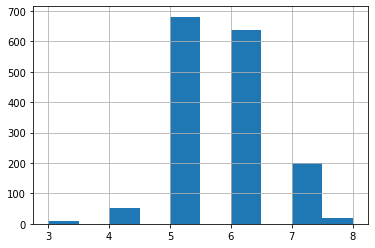

In [ ]:
# examine range of quality scores to see where we can split for two nearly balanced classes
wines['quality'].hist();

In [ ]:
# save the quality scores
quality = wines['quality']

# map quality scores to positive and negative labels
wines['good'] = wines['quality'].map(lambda x: x > 5);
wines = wines.drop(['quality'],axis=1)

# check the class balance
pos_fraction = wines['good'].sum()/wines['good'].count()
print(f'fraction of wines in the positive class is {pos_fraction:.2f}')

fraction of wines in the positive class is 0.53


### 2.2 Split the data randomly into stratified `train` (80%) and `test` (20%) sets.
Stratification ensures that the `train` and `test` splits contain similar proportions of data points from the two classes.

In [ ]:
# labels 
y = wines['good']

# features
X = wines.drop(['good'],axis=1)

In [ ]:
# split data, stratifying on class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)
X_train = pd.DataFrame(data=X_train, columns = X.columns)
X_test = pd.DataFrame(data=X_test, columns = X.columns)

In [ ]:
# check that class balance is similar in the train and test sets
n_train, n_test = len(y_train), len(y_test)
n_train_pos, n_test_pos = sum(y_train), sum(y_test)
print(f'n_train= {n_train}, n_train_pos/n_train = {n_train_pos/n_train:.3f}')
print(f'n_test= {n_test}, n_test_pos/n_test = {n_test_pos/n_test:.3f}')

n_train= 1279, n_train_pos/n_train = 0.535
n_test= 320, n_test_pos/n_test = 0.534


## 3. Exploratory Data Analysis (EDA)
For this part, we use only the `train` data set. <br>
No ***data snooping***!

### 3.1 Feature distributions
We'll visually examine the distrbutions of the features in three ways: histograms, densities, and box-and-whisker plots.

#### 3.1.1 Histograms show discrete (binned) distributions of the feature values
From the histograms we see that most of the features have exponential shapes with long tails, and some look nearly Gaussian.

In [ ]:
# all features except citric acid are strictly positive,
print(X_train.min(axis=0))

fixed acidity           4.60000
volatile acidity        0.12000
citric acid             0.00000
residual sugar          0.90000
chlorides               0.01200
free sulfur dioxide     1.00000
total sulfur dioxide    6.00000
density                 0.99007
pH                      2.86000
sulphates               0.37000
alcohol                 8.40000
dtype: float64


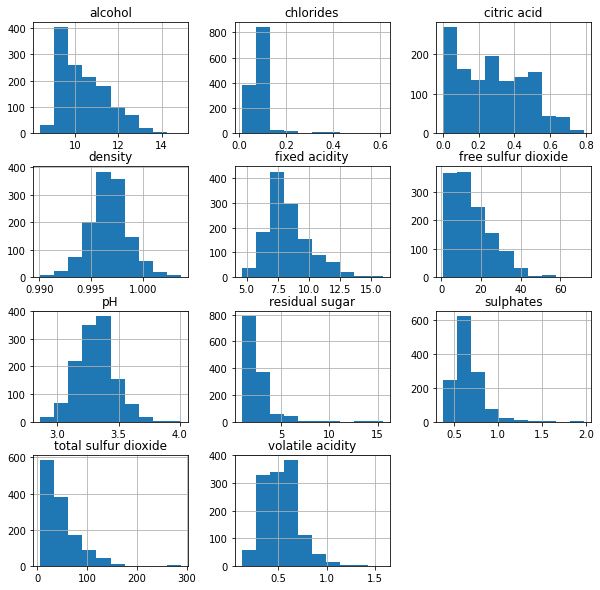

In [ ]:
# Histograms
X_train.hist(bins=10,figsize=(10,10))
plt.show()

#### 3.1.2 Densities estimate the continuous probability distributions of the feature values 

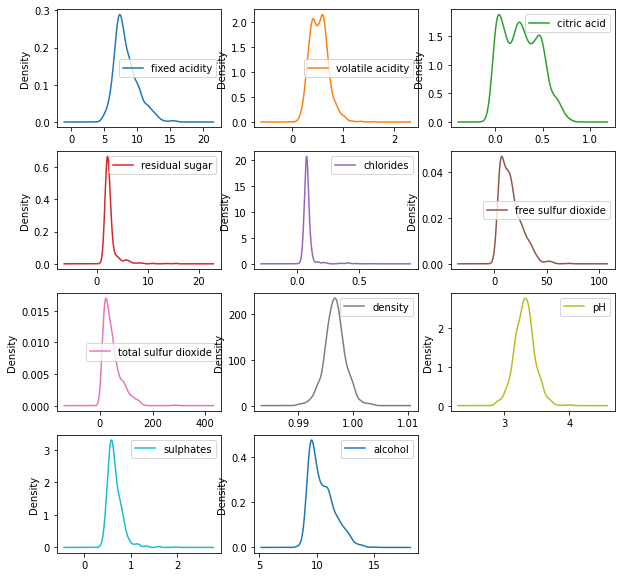

In [ ]:
# Density
X_train.plot(kind='density', subplots=True, layout=(4,3), sharex=False,figsize=(10,10))
plt.show()

#### 3.1.3 Box-and-Whiskers plots identify outliers
* the *Median* of the data is the line separating the **box** into two parts
* the *Second Quartile* of the data is the lower bound of the **box**
* the *Third Quartile* of the data is the upper bound of the **box**
* the *Inter-Quartile Range($IQR$)* is the height of the **box**
* the upper **whisker** extends to the largest data point within a distance of $1.5\cdot IQR$ above the **box**
* the lower **whisker** extends to the smallest data point within a distance of $1.5\cdot IQR$ below the **box**
* the range between the **bars** indicates the expected dispersion in the data
* **outliers** are indicated by small **circles** outside the **whiskers**

The box-and-whiskers plots show that features other than `alcohol` and `citric acid` have many outliers above the box. Since this is consistent with the long-tailed probability distibutions of these features, we will not remove the outliers.


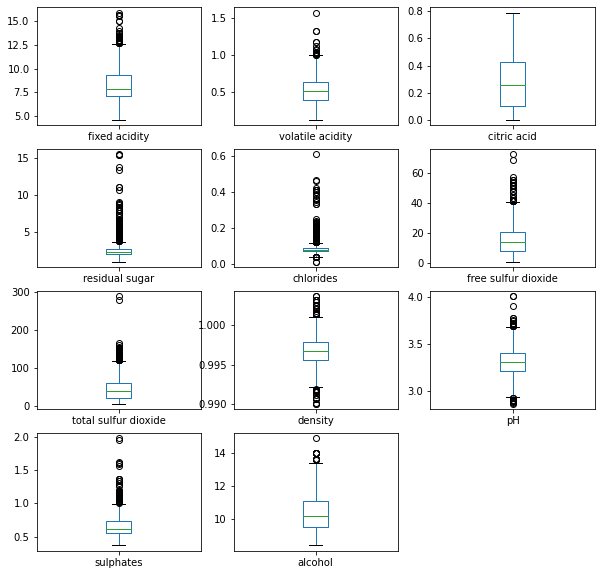

In [ ]:
# Box and whiskers plots
X_train.plot(kind='box', subplots=True, layout=(4,3), sharex=False,figsize=(10,10))
plt.show()

### 3.2 Correlations in the data
We'll look at pairwise feature scatter plots, correlations between pairs of features, and correlations between features and labels.

#### 3.2.1 Pairwise Feature Scatter Plots
Shows scatter plots for all possible pairs of features. <br>
Diagonal entries are the feature histograms.<br>
Scatter plots that follow systematic trends, such as upward or downward sloping lines, indicate that the associated features are correlated.


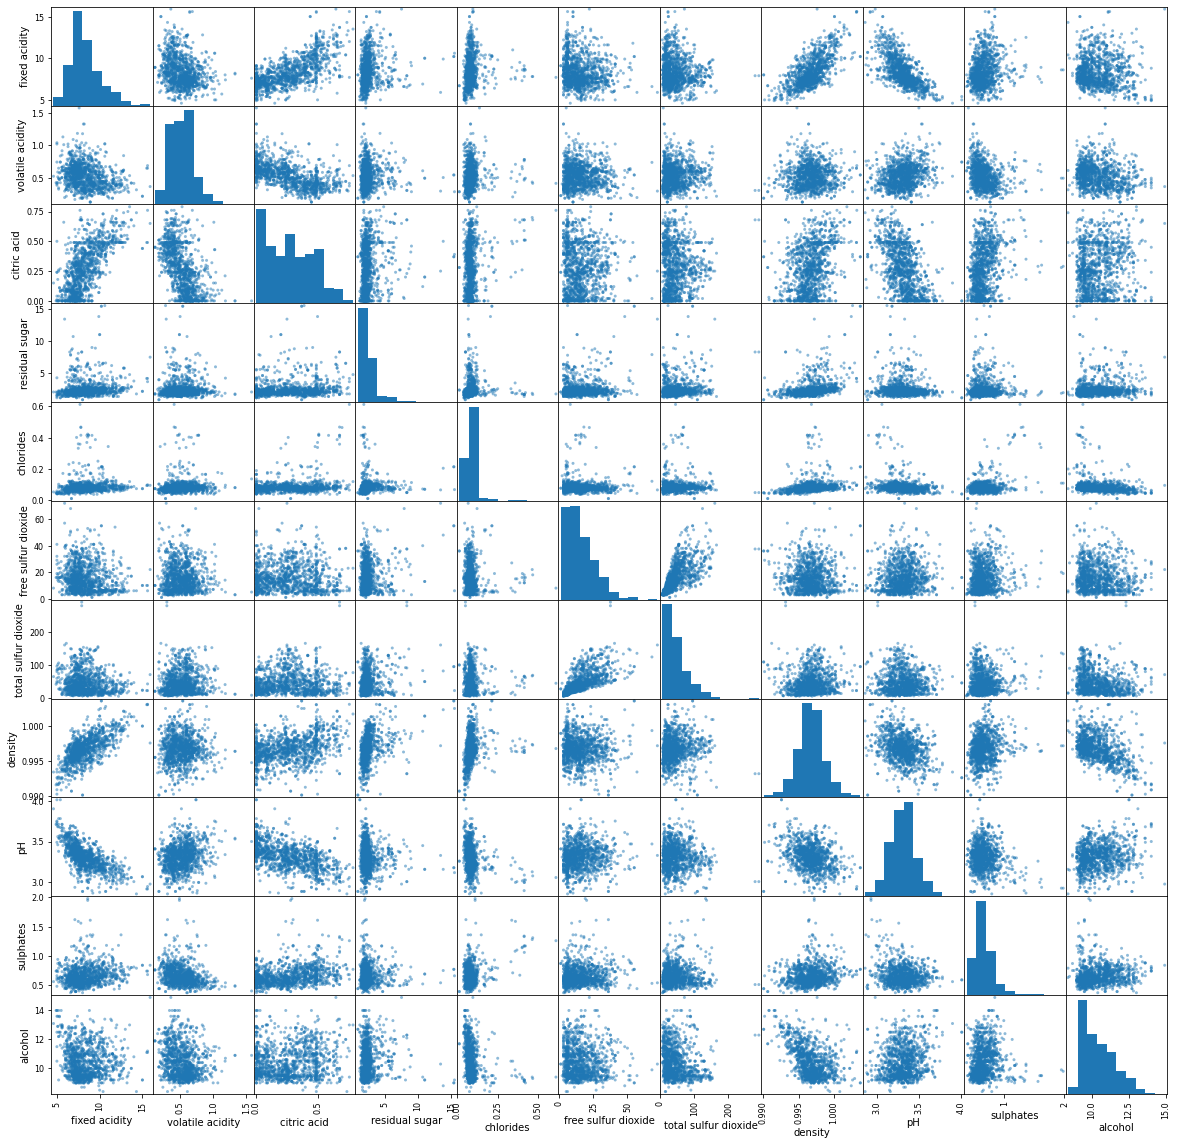

In [ ]:
# exploratory analysis
scatter_matrix(X_train, figsize= (20,20));

#### 3.2.2 Feature-feature correlations and and feature-label correlations
Pearson's Correlation measures the degree of similarity of two vectors <br>
Pearson's Correlation ranges from -1 to +1, with negative values indicating anti-correlation.<br>
Qualitative measures of correlation are Weak, Moderate and Strong, where<br>
Weak: $0 \le \lvert corr \rvert \lt 0.3$<br> 
Moderate: $0.3 \le \lvert corr \rvert \lt 0.7$<br> 
Strong: $0.7 \le \lvert corr \rvert \lt 1.0 $<br><br> 

We expect features that are correlated with the labels to have predictive power in our models. We find that `alcohol` and `acid volatility` features are moderately correlated with the label<br><br>
Correlated features have some degree of redundancy, and their importance measures may be systematically unreliable. <br>
Among the 55 unique feature pairs, we identify 12 pairs that are at least moderately correlated.

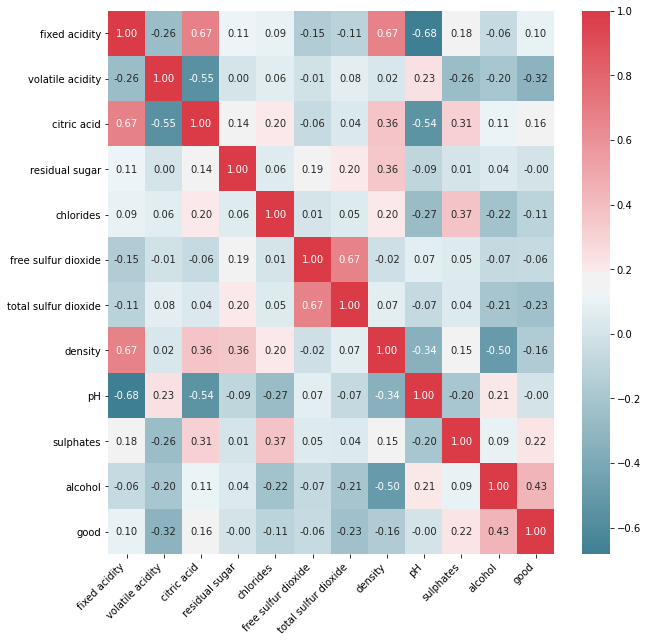

There are 12.0 of 55.0 feature pairs with moderate to strong correlation 


In [ ]:
# Correlation matrix

# Pearson's correlation coefficients
correlations = wines.corr()
# moderate and strong correlation is greater than 0.3
# plot figsize
fig, ax = plt.subplots(figsize=(10, 10))

# generate color map
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# generate heat map, allow annotations and place floats in map
sns.heatmap(correlations, cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    wines.columns,
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(wines.columns);
plt.show()

# count features that are more than weakly correlated
corr_features_only = correlations.iloc[range(len(correlations.columns[:-1]) ), range(len(correlations.columns[:-1]) )]
n_features = len(corr_features_only)
n_corr_features = ( ( (np.abs(corr_features_only.values)> 0.3) & (np.abs(corr_features_only.values)<=1) ).sum() - n_features )/2
print( f'There are {n_corr_features} of {(n_features**2 - n_features)/2} feature pairs with moderate to strong correlation ')


## 4. Data Preprocessing
In this section we prepare the data for modeling. <br>
We 'standardize' the data by subtracting the mean from each data point and dividing the result by the standard deviation. <br>
Features will then be centered on zero and have unit variance.<br>
We then consider using Principal Components Analysis (PCA) to create features with no correlation.

### 4.1 Standardize the test and train data
Caveat! Use the mean and standard deviation derived from the training data to standardize both the training data and the test data!

In [ ]:
# standardize data
scaler = StandardScaler()
# fit to the training data
scaler.fit(X_train)

#standardize the test and train data using mean and std parameters obtained from the train data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 4.2 Use PCA to construct uncorrrelated features?
PCA replaces the original features with independent linear combinations that are uncorrelated with each other. <br><br>
The downside of PCA is that we lose the ability to interpret the features. <br><br> 
PCA turned out to have negligible effect on the accuracy scores.<br><br>
So this case, we won't use it, as it offers no advantage.

In [ ]:
# Use PCA to construct independent features
#      from the original features, some of which are highly correlated
# 90% of the explained variance is in the first 8 components
# Omit PCA, since it doesn't change the scores much and it destroys interpretability
if(False):
    pca = PCA(n_components = 8,random_state=42)
    pca = pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # explained variance
    print(pca.explained_variance_ratio_)
    print(np.cumsum(pca.explained_variance_ratio_))

## 5. Select a set of models to compare, and instantiate a classifier for each model
Choose models that can compute class probabilities so that we can compute Receiver-Operating Curves (ROCs) and Precision-Recall Curves (PRCs). <br>
We choose four models: Random Forest, Multilayer Perceptron, Logistic Regression, and Naive Bayes. Of these, only the Random Forest and the Multilayer Perceptron have tunable hyperparameters.

In [ ]:
names = ["RandomForestClassifier", 
        "MLPClassifier", 
        "LogisticRegression",
        "GaussianNB",
        ]
        #"SVC",
        #"SVC RBF kernel",
        # "QuadraticDiscriminantAnalysis"
        #"GaussianProcessClassifier",
        #"AdaBoostClassifier"
        #"KNeighborsClassifier", 
        #"GradientBoostingClassifier",


classifiers = [
    RandomForestClassifier(max_depth = 5, min_samples_leaf=10, n_estimators=100, max_features=5, random_state=42),
    MLPClassifier(alpha=0.0001, max_iter=1000, learning_rate = 'adaptive', hidden_layer_sizes=(100,),early_stopping=True,random_state=42),
    LogisticRegression(random_state=42),
    GaussianNB()]
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma="scale", C=1),
    #QuadraticDiscriminantAnalysis()
    #GaussianProcessClassifier(1.0 * RBF(1.0),random_state=42),
    #AdaBoostClassifier(random_state=42),
    # KNeighborsClassifier(n_neighbors = 1),#, weights = 'distance'),
    # GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1,random_state=42),


## 6. Compare Model Performance

### 6.1 Accuracy Scores and Receiver Operating Curves

RandomForestClassifier, prob: True, train_score 0.804, test_score 0.756
MLPClassifier, prob: True, train_score 0.754, test_score 0.738
LogisticRegression, prob: True, train_score 0.743, test_score 0.741
GaussianNB, prob: True, train_score 0.737, test_score 0.722
CPU times: user 690 ms, sys: 256 ms, total: 946 ms
Wall time: 677 ms


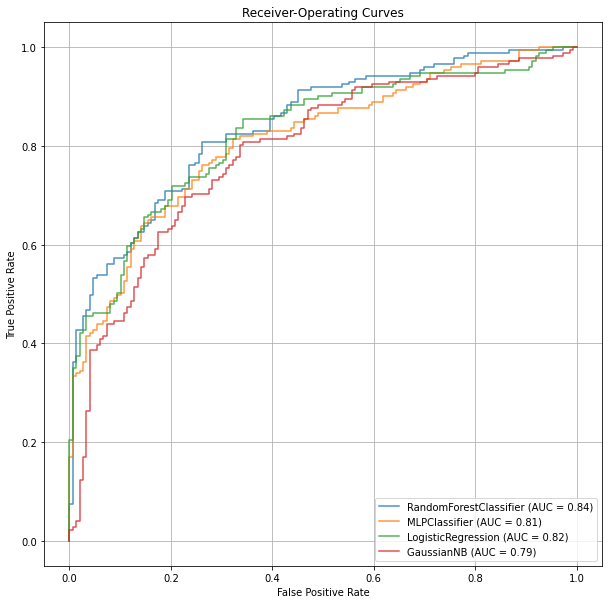

In [ ]:
%%time
clf = None
results = dict()
# iterate over classifiers
plt.figure(figsize=(10,10))
plt.title('Receiver-Operating Curves')
count=0
for clf,name in zip(classifiers,names):
    # fit model
    clf.fit(X_train, y_train)
    ax = plt.gca()
    clf_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
    plt.grid()
    #plt.show()
    # get scores
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
     
    print(f'{name}, prob: {hasattr(clf, "predict_proba")}, train_score {train_score:.3f}, test_score {test_score:.3f}')
    results[count] = [clf,train_score,test_score]
    count+=1
plt.grid()


### 6.2 Confusion Matrix
The confusion matrix gives us a quick look at where the classifier works best and where it fails. The upper left quadrant is the True Negatives, bad wines that were correctly classified as bad. The upper right quadrant is the False Positives, bad wines that were incorrectly classified as good. The lower left quadrant is the False Negatives, good wines that were incorrectly classified as bad. The lower right quadrant is the True Positives, good wines that were correctly classified as good. The Random Forest model has the smallest number of misclassifications = False Positives + False Negatives.

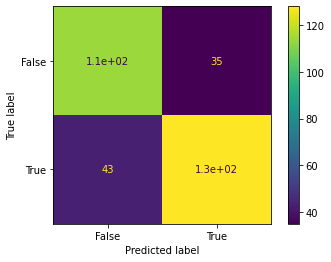

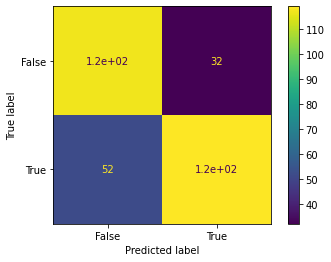

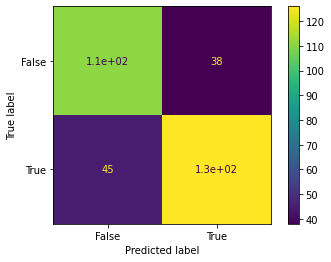

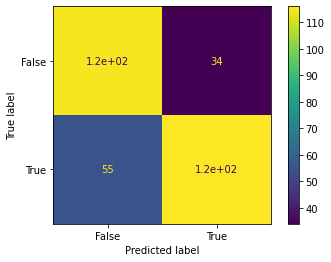

In [ ]:
# Plot Confusion matrix each classifier
clf = None
for clf in classifiers:
    # fit model
    clf.fit(X_train, y_train)
    conf_disp = plot_confusion_matrix(clf, X_test, y_test)

### 6.3 Model Interpretability: Feature Permutation Importances
The following procedure enables us to gauge the 'importance' of a feature, for any model:<br> 
* In the test set replace that feature column by a random permutation of itself
* Run the classifier on the test set with the permuted column 
* The ***permutation importance*** of that feature is defined as the difference in the model accuracy between the original and permuted data sets.<br>

High feature importance corresponds to significant loss in accuracy when the feature's values are scrambled, meaning the model depends on that feature to make correct classifications. <br><br>
Low feature importance corresponds to a small change in accuracy when the model is deprived of the information from that feature, indicating that feature has little relevance to the model.<br><br>
We find that permutation importances are relatively consistent across all the models we tested: `alcohol` is the most important feature, and `volatile acidity` is always the second or third most important feature<br><br>

We noted earlier that `alcohol` and `volatile acidity` are highly correlated and moderately correlated with the label, respectively. So it's not surprising that these turn out to be key features for classifying red wines!

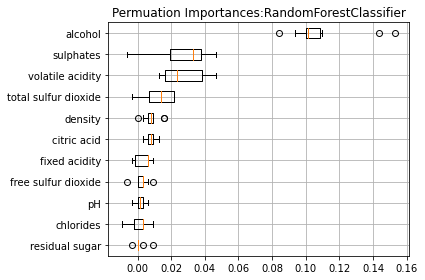

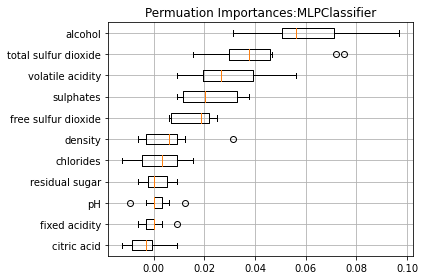

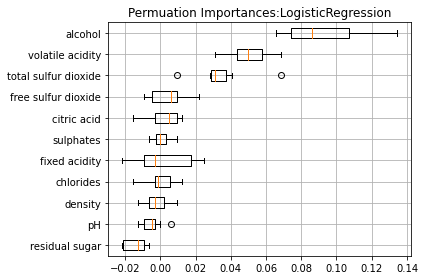

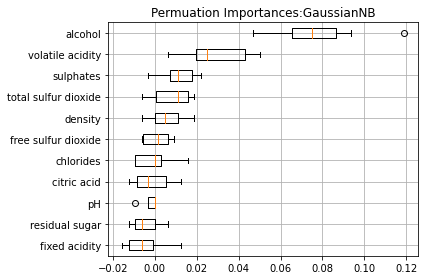

In [ ]:
# Compute permutation importances on test data
clf = None
clfs = dict()
count = 0
for name, clf in zip(names,classifiers):
    
    clf.fit(X_train, y_train)
    clfs[count] = clf
    result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.title('Permutation Importances:'+name)
    plt.grid()
    plt.show()
    count+=1


## 6.4 Probability Calibration 
Check the degree of calibration of the predicted probabilities for the various models. <br>
If the probabilities are well-calibrated, then for an arbitrary probability $p$, the fraction of True positives among the samples with `predict_proba` near $p$ should also be close to $p$. <br><br>
Evidently, Random Forest, Multilayer Perceptron, and Linear Regression probabilities are reasonably well-calibrated, while Naive Bayes probabilities are systematically off. Perhaps the Naive Bayes model is more sensitive than the others to the assumption of Gaussian-distributed features.

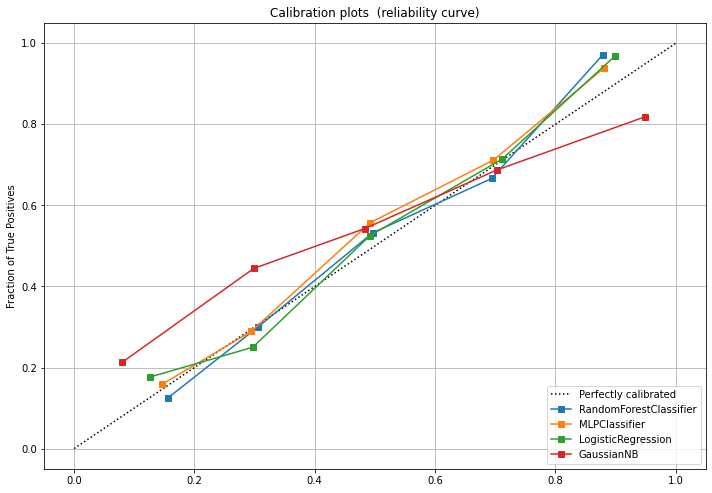

In [ ]:
# Calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
#ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=5,strategy='uniform')

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    #ax2.hist(prob_pos, range=(0, 1), bins=5, label=name,
    #         histtype="step", lw=3)

ax1.set_ylabel("Fraction of True Positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')
ax1.grid()

#ax2.set_xlabel("Mean predicted probability of Positive class")
#ax2.set_ylabel("Count")
#ax2.legend(loc="lower center", ncol=2)
#ax2.grid()

plt.tight_layout()
plt.show()

## 7. Model Selection
Comparison of the ROC-AUC scores, the total misclassifications from the confusion matrix, and the degree of probability calibration for the four models shows the Random Forest to be the best-performing model. At this point, we should really do a grid search to see if we can improve the performances of both the Random Forest and Multilayer Perceptron models, and then choose the best. We leave that as an exercise. Going forward, we will select the Random Forest Model.

### 7.1 Random Forest: AUC metric and its uncertainty
Cross-validation on the training data allows us to compute the AUC metric and its uncertainty

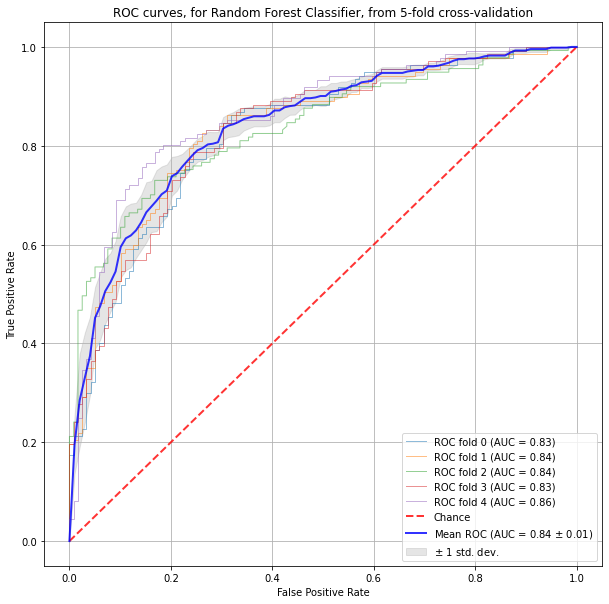

In [ ]:
#  K-fold cross-validation
cv = StratifiedKFold(n_splits=5)

clf = classifiers[0]

tprs = []
aucs = []
scores = []
mean_fpr = np.linspace(0, 1, 100)

XX, yy = X_train, y_train

fig, ax = plt.subplots(figsize=(10,10))
for fold, (train, test) in enumerate(cv.split(XX, yy)):
    # fit to the current fold in the training data
    clf.fit(XX[train], yy.iloc[train])
    viz = plot_roc_curve(clf, XX[test], yy.iloc[test],
                         name='ROC fold {}'.format(fold),
                         alpha=0.5, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    # accuracy scores
    train_score = clf.score(XX[train], yy.iloc[train])
    test_score = clf.score(XX[test], yy.iloc[test])
    scores.append((train_score,test_score))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curves, for Random Forest Classifier, from 5-fold cross-validation")
ax.legend(loc="lower right")
plt.grid()
plt.show()

### 7.2 Random Forest: accuracy prediction
From the cross-validation results on the training set, we predict a model accuracy of $0.76\pm 0.01$<br>
Using the held-out test set we find our model has accuracy of 0.76, so we are right on the money!<br>
We can do a pretty good job of telling the good wines apart from the bad.

In [ ]:
# Predict generalization accuracy of the Random Forest model from cross-validation on train data set
scores=np.array(scores)
#  train and test scores from cross-validation
print(scores)
mean_train, mean_test  = np.mean(scores,axis=0)
std_train, std_test = np.std(scores,axis=0)
#print(f'train: mean {mean_train:.2f}, std {std_train:.2f} test: mean {mean_test:.2f}, std {std_test:.2f}')
print(f'Predicted generalization accuracy: mean {mean_test:.2f}, std {std_test:.2f}')

[[0.81036168 0.75      ]
 [0.81036168 0.765625  ]
 [0.81524927 0.74609375]
 [0.81231672 0.7578125 ]
 [0.81445312 0.78039216]]
Predicted generalization accuracy: mean 0.76, std 0.01


In [ ]:
# Compare to actual generalization accuracy from applying the model to the held-out test data set
clf = classifiers[0]
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
test_score = clf.score(X_test, y_test)
print(f'Actual generalization accuracy: {test_score:.2f}')

# classification report
print('Classification report')
print(classification_report(y_test, y_preds))

Actual generalization accuracy: 0.76
Classification report
              precision    recall  f1-score   support

       False       0.73      0.77      0.75       149
        True       0.79      0.75      0.77       171

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



## 8. Learning experiences: choose several that you find interesting or challenging!



### 8.1 Hyperparameter optimization
Look up the documentation for `sklearn.model_selection.GridSearchCV`. Using only the training data, see if you can improve the performances of both the Random Forest and the Multilayer Perceptron models. Which model is now the best?

### 8.2 Ensembling
Combine the predictions of the Random Forest, Multilayer Perceptron, and Logistic Regression models. To do this, run each model on the test set, then classify each wine as the majority class among the three models. Was the accuracy of the Combined Model better than that of the Random Forest?

### 8.3 White wines
The UCI wine database also includes a white wine data set. For white wines, map wine quality scores of 7 and above to the positive class and scores below 7 to the negative class. Are the classes balanced? Repeat the steps in this notebook, and compare the F1 scores for the white and red data sets. If the F1 scores for the white wines were better/worse than for the red wines, why do you think this happened? Install the `imbalanced learn` package and see if the scores can be improved by using the `SMOTE` upsampling technique.

### 8.4 SHAP values
SHAP values offer a principled path to model explainability, by quantifying the degree to which each feature is to 'blame' for each classification. Find out about SHAP values, implement them for our Random Forest model, and discuss your results.


### 8.5 Receiver Operating Curves
Find and read a few good blogs or articles about ROC curves. Write code to create the ROC curve for the Random Forest model, from scratch. Check your result against the `sklearn` ROC curve.

### 8.6 Precision Recall Curves
Find and read a few good blogs or articles about Precision-Recall curves. Write code to create the PR curve for the Random Forest model, from scratch. Check your result against the sklearn PR curve. In what situation might the PR curve be give more useful information than the ROC curve, and why?

### 8.7 Data Leakage
What would happen to the test accuracy score if (say) 10% of the test examples are duplicates from the training set? Write code to try this, and report your finding. Also, write code to check whether the red wine data has duplicates and report your finding.

### 8.8 Data Snooping
What do you think would happen to the test accuracy score if you standardize the test data by its own mean and standard deviation, instead of using the mean and standard deviation from the training set? Try it and find out!

### 8.9 Telling a great wine apart from a mediocre one
Repeat the modeling process, this time starting with the positive class consisting of wines of quality 7 or better (i.e. great), and the negative class consisting only of wines of quality 5 (i.e. mediocre). Do you expect the new model to perform better or worse than the original model? Why? Discuss you results. How well does your model distinguish the great wines from the mediocre ones?

### 8.10 Unraveling the Confusion Matrix
For the Random Forest model we built, make a histogram of the quality score for each of the four groups of wines in the test set that were identified as False Positives, False Negatives, True Positives, and True Negatives. What trends do you notice? Do your results make sense? Discuss.

### 8.11 Missing Values
Our wine data had no missing values. This is seldom the case in most data sets you will encounter. Explore what happens if you randomly set 20% of the entries in the `wines` matrix of section $1$ to `null`. For both the training and test sets, impute each missing value as the median of the corresponding feature value in the training set. How do the four models fare under this attack? Which model was the most robust, i.e had the lowest performance hit?

### 8.12 Visualizing a Decision Tree
Run sklearn's`DecisionTreeClassifier` on the red wine dataset. Find out how to visualize a decision tree model using `graph_viz`, and apply this to your classifier. What can you learn from examining the decision tree?

# Congratulations on making through this notebook!
Together we've solved one of life's major problems for a wine aficionado! Provided you can get wine quality scores for wines the that you are considering buying, and that you choose the wines that our model rates as good, you can be much more confident that you will enjoy the next bottle of wine you bring home!